In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear\algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
import holoviews as hv
import seaborn as sns 
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from glob import glob

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from ortools.graph import pywrapgraph
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

/kaggle/input/hashcode-drone-delivery/busy_day.in
/kaggle/input/hashcode-drone-delivery/hashcode_delivery_instructions.pdf


# Data reading

In [2]:
with open('../input/hashcode-drone-delivery/busy_day.in') as file:
    data_list = file.read().splitlines()

In [3]:
data_list[2]
print('rows of grid,columns of grid,drones,turns, maxpay load in units(u):',data_list[0], 
      '\n Different product types:',data_list[1],
     '\n product types weigh:',data_list[2],
      '\n warehouses:',data_list[3],
      '\n First warehouse location at first warehouse (row, column):',data_list[4],
      '\n Inventory of products:',data_list[5],
      '\n second warehouse location (row, column)  :',data_list[6],
      '\n Inventory of products at second ware house:',data_list[7],
      '\n Number of orders:',data_list[24],
      '\n First order to be delivery at:',data_list[25],
      '\n Number of items in order:',data_list[26],
      '\n Items of product types:',data_list[27]    )

rows of grid,columns of grid,drones,turns, maxpay load in units(u): 400 600 30 112993 200 
 Different product types: 400 
 product types weigh: 73 40 84 107 52 36 13 74 36 94 93 46 123 24 100 93 62 49 97 102 80 37 22 25 72 48 40 74 32 31 136 64 99 37 44 36 104 74 112 40 65 67 50 143 23 26 91 20 142 128 9 77 40 26 55 104 59 112 42 69 87 89 2 11 105 43 105 23 21 88 57 40 52 63 35 141 54 27 45 37 21 37 102 38 36 117 57 93 24 52 83 133 51 102 34 52 39 54 64 146 127 100 58 50 49 40 55 123 64 30 127 63 19 59 31 22 68 37 107 68 52 61 35 38 76 44 21 144 21 40 105 48 97 70 74 95 75 28 25 40 81 72 58 99 52 5 72 84 53 21 110 97 30 43 92 109 39 89 51 30 102 94 13 45 93 94 90 104 36 55 92 12 45 126 73 132 118 127 125 26 83 69 49 39 4 63 84 47 75 43 82 43 51 28 118 110 42 2 53 74 54 57 92 23 72 95 76 35 38 100 52 34 58 74 86 25 32 61 39 55 76 68 107 82 97 108 57 38 88 71 22 40 63 37 80 51 52 52 67 101 49 46 100 52 63 36 53 45 51 56 71 50 13 29 18 36 87 86 39 11 148 74 74 121 11 28 65 79 32 85 95 26 

In [4]:
def list_lines(lines):
    """Returns a list of integer lists."""
    line_list = [[int(n) for  n in ll.split()] for ll in lines]
    return line_list


def set_params(line_list):
    top_line = line_list[0]
    params = {'DRONE_COUNT': top_line[2],
              'WT_CAP': top_line[4],
              'END_TIME': top_line[3],
              }
    return params


def find_wh_lines(line_list):
    """Provides the dividing line between warehouse and
    order sections in the line list."""
    wh_count = line_list[3][0]
    wh_endline = (wh_count*2)+4
    return wh_endline


def get_weights(line_list):
    weights = np.array(line_list[2])
    return weights.astype(np.int16)


def get_inventories(line_list):
    """Returns a 2-d array of P products by W warehouses."""
    wh_endline = find_wh_lines(line_list)
    invs = line_list[5:wh_endline+1:2]
    supply = np.array(invs).transpose()
    return supply.astype(np.int16)


def get_orders(line_list):
    """Returns a 2-d array of P products by C orders."""
    wh_endline = find_wh_lines(line_list)
    demand = np.zeros((line_list[1][0], line_list[wh_endline][0]),
                            dtype=np.int16)
    orders = line_list[wh_endline+3::3]
    for i,ord in enumerate(orders):
        for prod in ord:
            demand[prod, i] += 1
    return demand.astype(np.int16)


def get_locs(line_list):
    wh_endline = find_wh_lines(line_list)
    wh_locs = np.array(line_list[4:wh_endline:2])
    cust_locs = np.array(line_list[wh_endline+1::3])
    return wh_locs.astype(np.int16), cust_locs.astype(np.int16)
def xysplit(ary):
    return ary[:,:-1].flatten().tolist(), ary[:,-1].flatten().tolist()

In [5]:
line_list = list_lines(data_list)

params = set_params(line_list)
supply = get_inventories(line_list)
demand = get_orders(line_list)
wh_locs, cust_locs = get_locs(line_list)
weights = get_weights(line_list)

In [6]:
# The number of different types of products in 10 warehouses + information about the weight of the product
cols=[f'warehouse_{i}' for i in range(1,11)]
Prod_in_warehouses_df = pd.DataFrame(supply.T).T
Prod_in_warehouses_df.columns=cols
Prod_in_warehouses_df['weights'] = weights
Prod_in_warehouses_df['count']  =  [sum(supply[i]) for i in range(400)]
Prod_in_warehouses_df

,warehouse_1,warehouse_2,warehouse_3,warehouse_4,warehouse_5,warehouse_6,warehouse_7,warehouse_8,warehouse_9,warehouse_10,weights,count
0,0,0,0,1,1,0,1,0,1,1,73,5
1,0,0,0,0,0,16,0,0,0,0,40,16
2,5,3,1,4,6,3,6,6,8,4,84,46
3,1,1,3,0,1,0,0,0,1,2,107,9
4,0,1,0,1,2,1,1,0,0,0,52,6
...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,0,0,0,0,33,0,0,0,0,114,33
396,11,5,5,6,2,5,5,8,11,7,105,65
397,6,7,5,5,2,9,5,6,6,5,41,56
398,7,11,5,8,6,5,5,9,13,6,52,75


In [7]:
#The coordinates of the warehouses
X_warehouses, y_warehouses = xysplit(wh_locs)
warehouse_df = pd.DataFrame({'X_warehouses': X_warehouses, 'y_warehouses': y_warehouses}).astype(np.int32)
warehouse_df

,X_warehouses,y_warehouses
0,113,179
1,234,599
2,195,89
3,215,207
4,220,326
5,182,193
6,75,418
7,228,140
8,310,26
9,297,423


In [8]:
#The coordinates of the customers
X_customers, y_customers = xysplit(cust_locs)
customers_df = pd.DataFrame({'X_customers': X_customers, 'y_customers': y_customers}).astype(np.uint16)
customers_df

,X_customers,y_customers
0,340,371
1,163,320
2,201,331
3,257,290
4,115,512
...,...,...
1245,138,331
1246,109,273
1247,161,291
1248,127,152


In [9]:
#Count of each product type in the order
cols_order =[f'prod_{i}' for i in range(1,401)]
Prod_in_order_df = pd.DataFrame(demand.T).fillna(0)
Prod_in_order_df.columns=cols_order
w = []
for i in range(0,1250):
    w.append(sum(np.multiply(Prod_in_order_df.iloc[i:i+1].astype(int).values.tolist()[0],Prod_in_warehouses_df['weights'])))
Prod_in_order_df['total weight'] = w
Prod_in_order_df['count'] = [sum(demand.T[i]) for i in range(1250)]
Prod_in_order_df

,prod_1,prod_2,prod_3,prod_4,prod_5,prod_6,prod_7,prod_8,prod_9,prod_10,...,prod_393,prod_394,prod_395,prod_396,prod_397,prod_398,prod_399,prod_400,total weight,count
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,419,8
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,45,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,88,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,702,10
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,508,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,550,8
1246,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,731,8
1247,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,944,14
1248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,193,5


In [10]:
# Full information about the orders
order_information = Prod_in_order_df.join(customers_df)
order = [f'order №{i}' for i in range(1,1251)]
order_information.index = order 
order_information.insert(0, 'id', [i for i in range(1,1251)])
order_information

,id,prod_1,prod_2,prod_3,prod_4,prod_5,prod_6,prod_7,prod_8,prod_9,...,prod_395,prod_396,prod_397,prod_398,prod_399,prod_400,total weight,count,X_customers,y_customers
order №1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,419,8,340,371
order №2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,45,1,163,320
order №3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,88,2,201,331
order №4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,702,10,257,290
order №5,5,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,508,8,115,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
order №1246,1246,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,550,8,138,331
order №1247,1247,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,731,8,109,273
order №1248,1248,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,944,14,161,291
order №1249,1249,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,193,5,127,152


In [11]:
# Full information about the warehouses
cols_order =[f'prod_{i}' for i in range(1,401)]
warehouses_information = pd.DataFrame(supply.T)
warehouses_information .columns=cols_order
warehouses_information ['count'] = [sum(supply.T[i]) for i in range(10)]
sum_weights = []
for i in Prod_in_warehouses_df.columns[0:10]:
        sum_weights.append(sum(np.multiply(list(Prod_in_warehouses_df[str(i)]),Prod_in_warehouses_df['weights'])))
warehouses_information ['total weight'] = sum_weights
warehouses_information = warehouses_information.join(warehouse_df)
warehouses_information.index = cols 
warehouses_information.insert(0, 'id', [i for i in range(1,11)])
warehouses_information

,id,prod_1,prod_2,prod_3,prod_4,prod_5,prod_6,prod_7,prod_8,prod_9,...,prod_395,prod_396,prod_397,prod_398,prod_399,prod_400,count,total weight,X_warehouses,y_warehouses
warehouse_1,1,0,0,5,1,0,0,0,0,2,...,0,0,11,6,7,0,1450,89574,113,179
warehouse_2,2,0,0,3,1,1,0,0,0,2,...,0,0,5,7,11,0,1423,91170,234,599
warehouse_3,3,0,0,1,3,0,0,0,36,4,...,0,0,5,5,5,0,1394,99945,195,89
warehouse_4,4,1,0,4,0,1,0,15,0,2,...,0,0,6,5,8,0,1659,104414,215,207
warehouse_5,5,1,0,6,1,2,0,0,0,2,...,25,0,2,2,6,0,1155,70271,220,326
warehouse_6,6,0,16,3,0,1,0,0,0,5,...,0,33,5,9,5,0,1403,79153,182,193
warehouse_7,7,1,0,6,0,1,0,0,0,10,...,0,0,5,5,5,60,1602,113713,75,418
warehouse_8,8,0,0,6,0,0,0,0,0,5,...,0,0,8,6,9,0,1437,91339,228,140
warehouse_9,9,1,0,8,1,0,33,0,0,1,...,0,0,11,6,13,0,1619,114935,310,26
warehouse_10,10,1,0,4,2,0,0,0,0,6,...,0,0,7,5,6,0,1434,92319,297,423


# Visualization

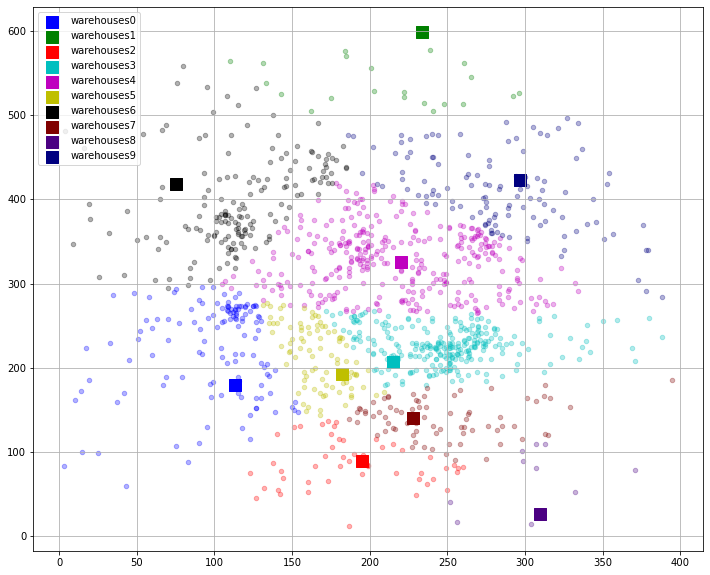

In [12]:
# Clustering by warehouse
def cluster_points(X, mu):
    clusters  = {}
    nearest_wh = []
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) for i in enumerate(mu)], key=lambda t:t[1])[0]
        nearest_wh += [bestmukey]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters, nearest_wh
clsr, nearest_wh = cluster_points(cust_locs , wh_locs)
x = range(400)
y = range(400,600)
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(111)
colors_1 = np.random.rand(50)
coll = ['b','g','r' ,'c','m','y','k' ,'maroon','indigo','navy']
for i in range(10):
    x, y = zip(*clsr.get(i))
    ax1.scatter(x, y,c = coll[i], s=20,alpha= 0.3)
    ax1.scatter(warehouse_df['X_warehouses'][i], warehouse_df['y_warehouses'][i],c = coll[i],marker="s", s=150,label=f'warehouses{i}',alpha=1)
plt.legend(loc='upper left')
ax1.grid(axis = 'both')
plt.show()

# добавляем информацию о ближайшем складе

order_information['nearest_wh'] = nearest_wh

In [13]:
def assign_whs(supply, wh_locs, demand, cust_locs,weights):
    """OR-tools function to assign warehouses to orders using a max-flow min-cost
    solver. Numbering scheme is as follows:
        warehouses = 1250 to 1259
        customers/orders = 0 to 1249
    
    Supply and demand do not have to be equal.
    """
    assignments = []
    count = 0
    distances = distance_matrix(cust_locs, wh_locs)

    for i in range(400):  # iterate over products
        item_count = 0

        # Network description
        start_nodes = np.repeat(np.arange(1250,1260), 1250).tolist()
        end_nodes = np.tile(np.arange(0,1250), 10).tolist()        
        capacities = np.tile(demand[i], 10).tolist()
        costs = np.transpose(distances).ravel().astype(int).tolist()
        supplies = np.negative(demand[i]).tolist() + supply[i].tolist()
                                            # nodes in numerical order
        # Build solver
        min_cost_flow = pywrapgraph.SimpleMinCostFlow()

        for s in range(len(start_nodes)):
            min_cost_flow.AddArcWithCapacityAndUnitCost(
                start_nodes[s], end_nodes[s], capacities[s], costs[s]
                )
        for s in range(len(supplies)):
            min_cost_flow.SetNodeSupply(s, supplies[s])

        # Solve
        if min_cost_flow.SolveMaxFlowWithMinCost() == min_cost_flow.OPTIMAL:
            for arc in range(min_cost_flow.NumArcs()):
                if min_cost_flow.Flow(arc) > 0:
                    for j in range(int(min_cost_flow.Flow(arc))):
                        warehouse = min_cost_flow.Tail(arc) - 1250
                        customer = min_cost_flow.Head(arc)
                        product = i
                        w = weights[i]
                        quant = 1
                        cost = min_cost_flow.UnitCost(arc)
                        assign = [warehouse, customer, product, quant, cost,w]
                        assignments.append(assign)
                        item_count += quant
        count += item_count             
    return np.array(assignments)
assignments = assign_whs(supply, wh_locs, demand, cust_locs,weights)
assign_df = pd.DataFrame(assignments, columns=['warehouse', 'cust', 'num',
                                               'count', 'dist','weight'])
assign_df

,warehouse,cust,num,count,dist,weight
0,3,187,0,1,36,73
1,4,777,0,1,176,73
2,5,99,1,1,159,40
3,5,148,1,1,88,40
4,5,295,1,1,89,40
...,...,...,...,...,...,...
9363,6,1169,399,1,175,60
9364,6,1180,399,1,211,60
9365,6,1181,399,1,269,60
9366,6,1207,399,1,85,60


In [14]:
def availability_check(i):
    df = assign_df[assign_df.cust == i].reset_index(drop=True)
    return df

In [15]:
# считаем сколько нужно отправить дронов к каждому складу

drons_count = int(data_list[0].split(' ')[2])
wh_count = len(warehouse_df)
orders_count_near_i_wh = []
for i in range(wh_count):
    orders_count_near_i_wh += [len(clsr[i])]
orders_count_near_i_wh = np.array(orders_count_near_i_wh)

orders_count_near_i_wh = np.around(orders_count_near_i_wh/(orders_count_near_i_wh.sum()/drons_count))
if sum(orders_count_near_i_wh == 0):
    drons_count_in_wh = (orders_count_near_i_wh == 0) + orders_count_near_i_wh - (orders_count_near_i_wh == max(orders_count_near_i_wh))*sum(orders_count_near_i_wh == 0)
    drons_count_in_wh = np.int0(drons_count_in_wh)
    

In [16]:
# распределение дронов

drons_count_in_wh
drons_distribution = []
j = 0
for i in range(len(drons_count_in_wh)):
    drons_distribution += [list(np.array(range(0,drons_count_in_wh[i])) + j)]
    j += drons_count_in_wh[i]

In [17]:
drons_distribution 

[[0, 1, 2],
 [3],
 [4],
 [5, 6, 7, 8, 9, 10],
 [11, 12, 13, 14, 15, 16, 17],
 [18, 19],
 [20, 21, 22, 23],
 [24, 25],
 [26],
 [27, 28, 29]]

In [18]:
drons_location = [list(warehouse_df.iloc[0].values)]*30
goods_weight = np.array(data_list[2].split(' '), dtype='int16')

In [19]:
# считаем взаиморасположение складов

wh_relative_location = np.zeros([wh_count,wh_count])
for i in range(wh_count):
    for j in range(wh_count):
        wh_relative_location[i,j] = np.ceil(np.linalg.norm(warehouse_df.iloc[i] - warehouse_df.iloc[j]))
wh_relative_location = pd.DataFrame(wh_relative_location)

In [20]:
T = int(data_list[0].split(' ')[-2])
t = [0 for i in range(drons_count)]
comand_count = [0 for i in range(drons_count)]
total_score = 0
comands = ''
t_list = [0]*1250
count = 0 
for i in range(len(order_information)):
    availability = availability_check(i)
    score = 0

    cur_ts = t[drons_distribution[order_information.iloc[i][-1]][0]:drons_distribution[order_information.iloc[i][-1]][-1]+1]
    dron_num = drons_distribution[order_information.iloc[i][-1]][cur_ts.index(min(cur_ts))]

    while len(availability) > 0:
        whs = list(set(availability.warehouse.tolist()))
        viewed_whs = []
        item_group = []
        item_group2 = []
        total_sum = 0

        df3 = availability.copy()
        while len(df3) > 0:
            df1 = ((warehouse_df.query('index in {}'.format(whs)) - drons_location[dron_num])**2)
            df1 = df1['X_warehouses'] + df1['y_warehouses']
            viewed_whs += [df1[df1 == df1.min()].index[0]]
            df2 = availability.query('warehouse in {}'.format(viewed_whs))
            df2 = df2.drop(item_group, axis=0)
            
            for j in range(len(df2)):
                if total_sum + df2.iloc[j].weight <= 200:
                    total_sum += df2.iloc[j].weight
                    item_group += [df2.index[j]]
                    item_group2 += [df2.iloc[j].num]
                    wh = df2.iloc[j].warehouse
                    distance = np.ceil(np.linalg.norm(drons_location[dron_num] - warehouse_df.iloc[wh]))
                    drons_location[dron_num] = warehouse_df.iloc[wh].tolist()
                    score += distance + 1
                    warehouses_information.iat[wh, df2.iloc[j].num + 1] -= 1
                    comands += str(dron_num) + ' L ' + str(wh) + ' ' + str(df2.iloc[j].num) + ' ' + '1\n'
                    count+=1
                    
            whs.remove(viewed_whs[-1])
            df3 = availability.query('weight + {} <= 200'.format(total_sum))
            df3 = df3.query('warehouse not in {}'.format(viewed_whs))
            drons_location[dron_num] = warehouse_df.iloc[viewed_whs[-1]].tolist()
            whs = list(set(df3.warehouse.tolist()))

        distance = np.ceil(np.linalg.norm(drons_location[dron_num] - order_information.iloc[i][403:405]))
        drons_location[dron_num] = order_information.iloc[i][403:405].tolist()
        score += distance
        for k in item_group2:
            comands += str(dron_num) + ' D ' + str(i) + ' ' + str(k) + ' ' + '1\n'
            count+=1

        availability = availability.query('index not in {}'.format(item_group))
        
        t[dron_num] += score
        total_score += np.ceil((T - t[dron_num])/T*100)
        t_list[i] = total_score 

In [21]:
count

18736

In [22]:
f = open('submission.csv','w')
f.write('18736\n')
for index in comands:
    f.write(index)
f.close()

In [23]:

import pandas as pd
import numpy as np
from tqdm import tqdm
print('Extracting data')

# =============================================================================
# load problem file
# =============================================================================
with open('/kaggle/input/hashcode-drone-delivery/busy_day.in') as file:
    line_list = file.read().splitlines()
    
# =============================================================================
# problem parameters
# =============================================================================
ROWS, COLS, DRONES, TURNS, MAXLOAD = map(int, line_list[0].split())
   
# =============================================================================
# load product information
# =============================================================================
weights = line_list[2].split()
products_df = pd.DataFrame({'weight': weights})

wh_count = int(line_list[3])
wh_endline = (wh_count*2)+4

wh_invs = line_list[5:wh_endline+1:2]
for i, wh_inv in enumerate(wh_invs):
    products_df[f'wh{i}_inv'] = wh_inv.split()

# products_df has shape [400,11]
# (# of products, [weight, wh0_inv, wh1_inv,...])
products_df = products_df.astype(int)

# =============================================================================
# load warehouse locations
# =============================================================================
wh_locs = line_list[4:wh_endline:2]
wh_rows = [wl.split()[0] for wl in wh_locs]
wh_cols = [wl.split()[1] for wl in wh_locs]

warehouse_df = pd.DataFrame(
    {'wh_row': wh_rows, 'wh_col': wh_cols}).astype(np.uint16)

# =============================================================================
# load order information
# =============================================================================
order_locs = line_list[wh_endline+1::3]
o_rows = [ol.split()[0] for ol in order_locs]
o_cols = [ol.split()[1] for ol in order_locs]

orders_df = pd.DataFrame({'row': o_rows, 'col': o_cols})

orders_df[orders_df.duplicated(keep=False)].sort_values('row')

orders_df['product_count'] = line_list[wh_endline+2::3]

order_array = np.zeros((len(orders_df), len(products_df)), dtype=np.uint16)
orders = line_list[wh_endline+3::3]
for i,order in enumerate(orders):
    products = [int(prod) for prod in order.split()]
    for p in products:
        order_array[i, p] += 1

df = pd.DataFrame(data=order_array,
                  columns=['p_'+ str(i) for i in range(400)],
                  index=orders_df.index)

orders_df = orders_df.astype(int).join(df)

print('... success')
# get list of drone commands
submission = pd.read_csv('submission.csv')
allcommands = submission[submission.columns[0]].values

# delivery_times will store the timestamp of the last delivery for each order
order_completion_times = np.full((len(orders_df)), -1)
# missing_items holds the number of each product required to complete an order
missing_items = orders_df.copy()
# inventory_ops simply lists all inventory changes of all warehouses
inventory_ops = pd.DataFrame(columns=['action', 'wh', 'item', 'count', 'turn'])

# iterate through all drones
for ddd in tqdm(range(DRONES)):
    
    # get only commands for this specific drone
    dronecommands = [iii for iii in allcommands if iii.split()[0] == str(ddd)]
    
    # all drones start at warehouse 0 at timestep 0 with 0 weight loaded
    currentloc = warehouse_df.loc[0].values
    currenttime = 0
    currentweight = 0
    
    # go through commands in order
    for cmd in dronecommands:
        
        # split command into separate components
        _, action, locidx, prod, count = cmd.split(' ')
        
        # for "wait" commands
        # add given number of turns to timer and continue
        if action == 'W':
            currenttime += locidx
            continue

        # get target location
        if action == 'L' or action == 'U':
            newloc = warehouse_df.loc[int(locidx)].values
        elif action == 'D':
            newloc = orders_df.loc[int(locidx), ['row', 'col']].values
        # calculate distance, round up to the next integer and add to timer
        dist = int(np.ceil(np.sqrt(np.sum((currentloc-newloc)**2))))
        currenttime += dist
        # add one step for loading / unloading / delivery itself
        currenttime += 1
        # check if end of simulation is reached
        if currenttime > TURNS:
            raise Exception('Maximum simulation time exceeded')
        # update current location
        currentloc = np.copy(newloc)
        
        # update drone weight
        if action == 'L':
            currentweight += int(count) * products_df.loc[int(prod),'weight']
        elif action == 'D' or action == 'U':
            currentweight -= int(count) * products_df.loc[int(prod),'weight']
        # check if drone weight limit exceeded  
        if currentweight > MAXLOAD:
            raise Exception('Maximum drone load exceeded')
        
        # for deliveries
        if action == 'D':
            # check number of items delivered and update required items
            if missing_items.at[int(locidx), 'p_{}'.format(prod)] >= int(count):
                missing_items.at[int(locidx), 'p_{}'.format(prod)] -= int(count)
                # note latest delivery for each order
                if currenttime > order_completion_times[int(locidx)]:
                     order_completion_times[int(locidx)] = currenttime
            else:
                raise Exception('Too many items delivered')
                
        # save list of loading / unloading operations for checking warehouse inventory
        if action == 'L' or action == 'U':
            inventory_ops = inventory_ops.append({
                'action': action,
                'wh': int(locidx),
                'item': int(prod),
                'count': int(count),
                'turn': currenttime
            }, ignore_index=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Extracting data
... success


100%|██████████| 30/30 [01:00<00:00,  2.03s/it]


In [24]:
for wh in range(len(warehouse_df)):
    for item in tqdm(range(len(products_df))):
        # all inventory operations at this warehouse involving this product
        tmp = inventory_ops[
            (inventory_ops['wh'] == wh) &
            (inventory_ops['item'] == item)            
        ]
        if not len(tmp):
            continue
        
        # sort chronologically
        tmp = tmp.sort_values(by='turn')
        # get initial stock
        inv = products_df.loc[item, f'wh{wh}_inv']
        # if overall fewer or just as many products are removed as are stored
        # in the warehouse, no further checks needed
        if len(tmp[tmp['action'] == 'L']) <= inv:
            continue
        # otherwise, "simulate" loading and unloading to see
        # whether inventory goes negative
        for iii in tmp.index:
            if tmp.loc[iii, 'action'] == 'L':
                inv -= tmp.loc[iii, 'count']
            else:
                inv += tmp.loc[iii, 'count']
            # check inventory after each step
            if inv < 0:
                raise Exception('Removal of unstocked product attempted')



100%|██████████| 400/400 [00:01<00:00, 227.87it/s]


In [25]:

# check which orders are still missing items
completed = np.max(missing_items.iloc[:,3:].values > 0, axis=1) <= 0
print('Orders completed:', len(np.where(completed)[0]))
print('Orders not completed:', len(np.where(completed == False)[0]))
# sum up scores of all completed orders
order_scores = np.ceil(100 * (TURNS - order_completion_times[np.where(completed)[0]]) / TURNS)
print('Score:', int(np.sum(order_scores)))

Orders completed: 1250
Orders not completed: 0
Score: 93954
